In [25]:
# import all packages
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from itertools import combinations
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error


### Clean the Dataset
##### What to expect:
   * In part-I, we will *__clean the data__*, and will write down each step in detail.
        * Read CSV file
        * Remove columns which are not requierd in analysis. 
            * ['address', 'phone']
        * Rename columns to some intuitive names
        * Handle the null values [drop it]
            * The risk of bias arises if the imputed values are not representative of the true missing values, so we will remove missing values as we have enough dataset to work on.
        * Drop duplicates
        * Remove the irrelevant text from each column, if any
            * For example in rating column extract 4.1 from '4.1/5' and convert it to float type.
            * In 'online_order' column we want "Yes or No", so will remove records which have 
            values other than "Yes or No".
            * Convert ['votes', 'approx_cost'] columns to integer.
        * Check uniqueness of the data in each column 
             * If any nan value is created during conversion from string to float or int, handle those records with nan values.
        * Remove Non-printable characters from Name column



*__Note: First handle missing values and extract substring after that convert to numeric type as missing values and nan values might generate exception.__*

In [2]:
def read_data_from_csv():
    path = input('Enter the path to csv file:\t')
    restaurants=pd.read_csv(path)
    return restaurants


def remove_unwanted_columns():
    #call read_data_from_csv() function to get dataframe
    
    restaurants = read_data_from_csv()
    restaurants = restaurants.drop(columns=['address', 'phone'])
    
    return restaurants


def rename_columns():
    #call remove_unwanted_columns() function to get dataframe
    restaurants = remove_unwanted_columns()
    
    #rename columns,  only these columns will be used in the dataset
    restaurants.rename(columns={'rate':'rating',
                       'approx_cost(for two people)':'approx_cost',
                       'listed_in(type)': 'type'}, inplace=True)
   
    return restaurants


#handle  null values of each column
def null_value_check():
    
    #call rename_columns() function to get dataframe
    restaurants=rename_columns()
    
    #remove all null values from all columns
    restaurants.dropna(inplace=True)
    
    for col in restaurants.columns:
        
        cnt = restaurants[col].loc[restaurants[col].isnull() == True].count()

        if cnt != 0:
            print(f'Oops :(, Null values in {col} column')
            print(col, cnt)
        
    return restaurants


#find duplicates in the dataset
def remove_duplicates():
    
    #call null_value_check() function to get dataframe
    restaurants=null_value_check()
    
    #droping the duplicates value keeping the first
    restaurants.drop_duplicates(inplace=True)
    
    return restaurants


#removing irrelevant text from all the columns
def removing_irrelevant_text():
    
    #call remove_duplicates() function to get dataframe
    restaurants= remove_duplicates()
    
    
    #Extract ratings 4.1 from 4.1/5
    restaurants['rating'] = restaurants['rating'].str.extract(r'^(\d\.\d)')
    restaurants['rating'] = restaurants['rating'].astype(float)
    
    #Remove rows which contains value other than Yes or No
    restaurants = restaurants.loc[restaurants['online_order'].isin(['Yes', 'No'])]
    
    #Convert to float 
    restaurants['votes'] = restaurants['votes'].astype(int)
    restaurants['approx_cost'] = restaurants['approx_cost'].str.replace(',', '').astype(int)
    
    
    return restaurants


#check for unique values in each column and handle the irrelevant values
def check_for_unique_values():
    '''
    Handling or removing np.nan values which might arise during the extraction of ratings or 
    during conversion to float type.
    '''
    
    #call removing_irrelevant_text() function to get dataframe
    restaurants = removing_irrelevant_text()
    
    # Creating copy of the datafram as mutating the same dataframe might cause problems.
    restaurants_cp = restaurants.copy()
   

    for col in restaurants_cp.columns:
        if restaurants_cp[col].dtype != 'object':          
            for val in restaurants_cp[col].unique():
                if math.isnan(val) or np.isnan(val) or pd.isna(val):
                    #remove all those rows where val is np.nan 
                    restaurants = restaurants.loc[np.isnan(restaurants[col]) == False]
                    
    return restaurants


#remove the unknown character from the dataset and export it to "zomatocleaned.csv"
def remove_the_unknown_character():
    '''
    remove unknown character from dataset
    '''
    
    #call check_for_unique_values() function to get dataframe
    dataframe=check_for_unique_values()
    
    # define a regular expression pattern to remove unknown characters 
    # AsCII code for printable chars
    pattern = r'[^\x00-\x7F]+'

    # remove unknown characters from non-numeric columns
    for col in dataframe.columns:  
        if dataframe[col].dtype == 'object':
            dataframe[col] = dataframe[col].apply(lambda x: re.sub(pattern, '', x))

    
    
    #export cleaned Dataset to newcsv file named "zomatocleaned.csv"
#     dataframe.to_csv('zomato_cleaned.csv')
    return dataframe




def cleaned_data():
    '''
    Returns dataframe where all null values are handled, and 
    converts all columns to appropriate format.
    
    '''
    return remove_the_unknown_character()


In [3]:
df = cleaned_data()

Enter the path to csv file:	zomato.csv


In [4]:
df.head(3)

,name,online_order,book_table,rating,votes,location,rest_type,dish_liked,cuisines,approx_cost,type
0,Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,Buffet
1,Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,Buffet
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,Buffet


### Part-I Compare two samples

* Visualize and understand the dataset
* Make Hypothesis
* To validate that hypothesis let's run some tests:

    * First check if samples are independent 
    * check population distriubtion is normal if sample size is small
    * If sample size large enough and std deviation is unknow then use z-test


__I am going to use type of the restaurant, for examle delivery, dine-out, to compare average spending for each category.__

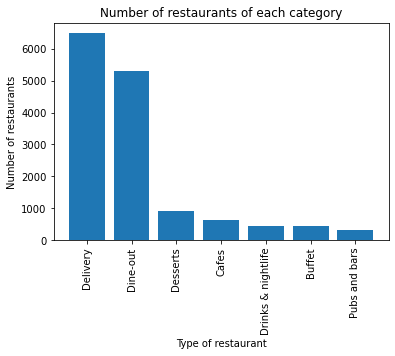

In [5]:
# Create a bar plot for each type of restaurants
plt.bar(df.type.value_counts().index,df.type.value_counts().values)

plt.title('Number of restaurants of each category')
plt.xlabel('Type of restaurant')
plt.ylabel('Number of restaurants')

# Rotate labels vertically
plt.xticks(rotation=90)

plt.show()

#### Check Independence
* To check samples are independent
* Check if same restaurants are appearing in both categories ['Delivery', 'Dine-out'] if yes then exclude those records  


In [6]:
def independent_samples(pk = ['name', 'location']):
    '''
    Selecting only independent samples. 
    
    This funciton will drop the restaurants with same name, location, 
    as it's possible that restaurant can have both delivery & dine-out or more facilities.
    Moreover, restaurant listed with same name & location can have different type.
    '''
    return df.drop_duplicates(subset=pk, keep='first')

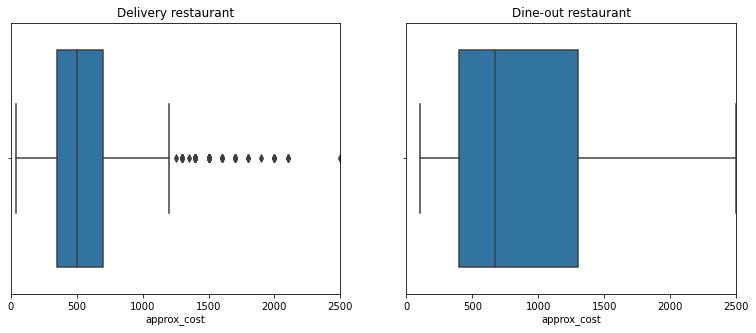

In [7]:
# Grouping the data for each category
ind_df = independent_samples()
groups_type = ind_df.groupby('type')

# Create box plot for each category
fig = plt.figure(figsize=(13,5))
cnt = 1
samples_d = {}

for name, group in groups_type:
    samples_d[str(name)] = group
    # Just using two categories for analysis
    if name in ['Delivery', 'Dine-out']:
        fig.add_subplot(1,2,cnt)
        sns.boxplot(group['approx_cost'])
        plt.title(f'{name} restaurant')
        plt.xlim(0,2500)

        cnt += 1
        

# ax.set_xlabel('Type of restaurant')
# ax.set_ylabel('approximate cost for two people')

plt.show()

### Hypothesis Procedures for Comparing two samples

In this section, we outline the hypothesis procedures for our study. 

##### My claim is that average cost of dining out is more as compared to delivery. 


- $H_0$: Average cost of Dining out is less or equl than Delivery.
- $H_1$: Average cost of Dining out is more than Delivery.

We will use a significance level of $\alpha = 0.05$.

Mapping: Delivery=1 , Dine-out=2

$H_0: \mu_1 \ge \mu_2$


$H_a: \mu_1 < \mu_2$

Sample size:  ($ n_1 + n_2 - 2) > 30$

sample size is large enough so by __Central limit theorem__ use independent __Z-test__

Test Statistic:
$z = \frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}}}$


Critical Value:
$z_{\alpha}$

Decision Rule:

Reject $H_0$ if $p_{value} < \alpha$


Fail to reject $H_0$ if $p_{value} > \alpha$

In [8]:
# Extract samples
sample1 = samples_d['Delivery'].approx_cost
sample2 = samples_d['Dine-out'].approx_cost

sample_size = sample1.shape[0] + sample2.shape[0] - 2 

if sample_size > 30:
    print('Sample size is:', sample_size)
    # calculate the test statistic
    sample1_var = sample1.var()
    sample2_var = sample2.var()
    z = (sample1.mean() - sample2.mean()) / \
                            np.sqrt(( sample1_var/ sample1.shape[0]) + (sample2_var/sample2.shape[0]))

# calculate the p-value
p = stats.norm.cdf(-abs(z))

# print the test statistic and p-value
print(f'\nz-statistic: {z: .4f}')
print(f'\np-value: {p: .4f}')

if p<0.05:
    print('\nReject Null hpyothesis')
    
elif p>0.05:
    print('\nFail to reject Null hypothesis')

Sample size is: 3619

z-statistic: -13.3531

p-value:  0.0000

Reject Null hpyothesis


Huray ! 

:) 
    
__My claim is true: Average cost of dining out is more than delivery.__

---------------------

##### Related samples in contex of same Hypothesis 

* Related samples are those restaurants which are listed as both Delivery & Dine-out. However,  approx_cost for Delivery is as same as Dine-out so it isn't good idea to compare those samples. 

* In addition to that restaurants listed on Zomato with same name & location might offer Delivery & Dine-out but calculation of approx_cost is based on cumulative sum that's why same approx_cost for two different types.

--------------

### Part-II ANOVA

### Hypothesis Procedure for ANOVA

In this section, we outline the hypothesis procedures for our study. 

##### My claim is that average cost of every type of restaurant is same. 


- $H_0$: Average cost for every type of restaurant is same.
- $H_1$: Average cost for every type of restaurant is not same.

We will use a significance level of $\alpha = 0.05$.

Mapping: Delivery=1 , Dine-out=2, Desserts=3, Cafes=4, Drinks & nightlife=5, Buffet=6,
            Pubs and bars=7.
            
$H_0: \mu_1 = \mu_2 = \mu_3 = \mu_4 = \mu_5 = \mu_6 = \mu_7$

$H_a: Not  \  {H_0}$

__One-way ANOVA__

I used the following method to perform the ANOVA test:

- Collected data from seven groups.
- Calculated the sum of squares within groups (SSW) and between groups (SSB).
- Calculated the degrees of freedom within groups (dfW) and between groups (dfB).
- Calculated the mean square within groups (MSW) and between groups (MSB).
- Calculated the F-statistic by dividing MSB by MSW.
- Compared the F-statistic to the critical value at the 5% significance level with degrees of freedom (dfB, dfW).
- Made a decision about whether to reject the null hypothesis.



Decision Rule:

Reject $H_0$ if $p_{value} < \alpha$


Fail to reject $H_0$ if $p_{value} > \alpha$

In [9]:
sample1 = samples_d['Delivery'].approx_cost
sample2 = samples_d['Dine-out'].approx_cost
sample3 = samples_d['Desserts'].approx_cost
sample4 = samples_d['Cafes'].approx_cost
sample5 = samples_d['Drinks & nightlife'].approx_cost
sample6 = samples_d['Buffet'].approx_cost
sample7 = samples_d['Pubs and bars'].approx_cost


# Perform one-way ANOVA test
f_stat, p_val = stats.f_oneway(sample1, sample2, sample3, sample4, sample5, sample6, sample7)

# Print results
print("F-statistic: {:.2f}".format(f_stat))
print("p-value: {:.4f}".format(p_val))

# Interpret results
if p_val < 0.05:
    print("Reject Null Hypothesis.")
    print("Conclusion: There is a significant difference between the cost for each type of restaurant.")
else:
    print("Fail to Reject Null Hypothesis.")
    print("Conclusion: There is no significant difference between the cost.")


F-statistic: 191.10
p-value: 0.0000
Reject Null Hypothesis.
Conclusion: There is a significant difference between the cost for each type of restaurant.


--------------

### Part-III Analysis of Categorical data

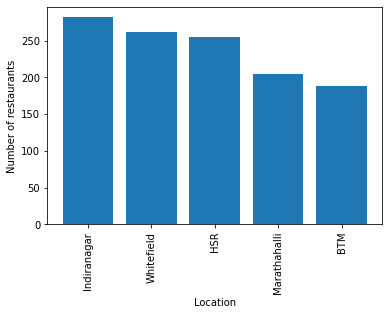

In [10]:
freq_table = ind_df.location.value_counts().head(5)
plt.bar(freq_table.index, freq_table.values)
plt.xticks(rotation=90)
plt.xlabel('Location')
plt.ylabel('Number of restaurants')
plt.show()

##### Claim: There might be a relationship between the type of restaurants that are present in certain localities. For example, certain areas might have more buffets and fewer pubs, while others might have more pubs and fewer buffets. This relationship might be due to factors such as the demographics of the area or the preferences of the people who live there.

In [11]:
top_5_locations = ind_df[ind_df['location'].isin(freq_table.index)]

contingency_table = pd.crosstab(top_5_locations['location'], ind_df['type'])

In [12]:
contingency_table

type,Buffet,Cafes,Delivery,Desserts,Dine-out,Drinks & nightlife,Pubs and bars
location,,,,,,,
BTM,4,4,146,7,27,0,0
HSR,3,11,212,10,17,1,1
Indiranagar,11,32,167,9,57,4,2
Marathahalli,10,2,158,4,27,2,1
Whitefield,13,9,175,8,55,1,1


In [13]:
chi2_stat, p_val, dof, expected_freq = stats.chi2_contingency(contingency_table)

In [14]:
# Print the results
print("Chi-square statistic:",round(chi2_stat,4))
print("Degrees of freedom:", dof)
print("p-value:", round(p_val,4))

# Make a hypothesis decision based on the p-value
if p_val < 0.05:
    print("Reject the null hypothesis: There is a significant association between the two variables.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between the two variables.")

Chi-square statistic: 86.6724
Degrees of freedom: 24
p-value: 0.0
Reject the null hypothesis: There is a significant association between the two variables.


Huray ! 

:) 
    
__My claim is true: There is relationship between the type of restaurants that are present in certain localities.__

---------------

### Part-IV Linear Regression

* Predict the rating of restaurant based on given attributes using simple regression model

In [15]:
# encode categorical variables
cat_cols = ['online_order', 'book_table', 'location', 'rest_type', 'dish_liked', 'cuisines', 'type']
encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])

# scale numerical variables
num_cols = ['rating', 'votes', 'approx_cost']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# split the data into training and testing sets
X = df.drop(['name', 'rating'], axis=1)
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# evaluate the model on the testing set
score = model.score(X_test, y_test)
print('R-squared score:', score)


R-squared score: 0.14706960901936983


------------

### Part-V & VI Resampling Methods & Linear model selection

Backward feature selection using the Bayesian Information Criterion (BIC) 

best subset size= 6


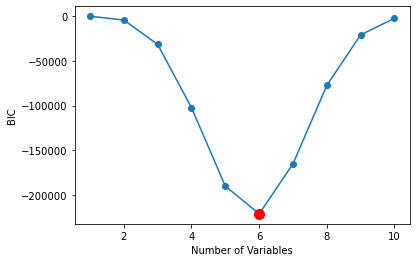

In [16]:
n_features = X.shape[1]
bic_values = np.zeros((n_features+1,))
n = X.shape[0]

for k in range(1, n_features+1):
    for subset in combinations(range(n_features), k):
        X_sub = X.iloc[:, list(subset)]
        model = LinearRegression().fit(X_sub, y)
        RSS = np.sum((y - model.predict(X_sub))**2)
        bic_values[k] += n*np.log(RSS/n) + k*np.log(n)
        
best_k = np.argmin(bic_values) + 1
print('best subset size=',best_k)

plt.plot(range(1, n_features+2), bic_values, '-o')
plt.xlabel('Number of Variables')
plt.ylabel('BIC')
plt.plot(best_k, bic_values[best_k-1], 'ro', markersize=10)
plt.show()

In [17]:
best_subset_idx = np.argsort(bic_values)[:best_k]
best_subset = X.iloc[:, best_subset_idx]
print('Best subset size=',best_k)
print('Best subset of features: ', list(best_subset.columns))

Best subset size= 6
Best subset of features:  ['dish_liked', 'rest_type', 'cuisines', 'location', 'approx_cost', 'votes']


----------------

Lasso Regression

In [23]:

# Define the number of folds for cross-validation
num_folds = 5

# Define the regularization parameter for Lasso
alpha = 0.01

# Initialize the k-fold cross-validation object
kf = KFold(n_splits=num_folds)

# Initialize an array to store the mean squared errors for each fold
mse = np.zeros(num_folds)

# Loop over the folds
for i, (train_index, test_index) in enumerate(kf.split(X)):
    
    # Split the data into training and test sets for this fold
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Create a Lasso regression model
    lasso = Lasso(alpha=alpha)
    
    # Fit the model on the training data
    lasso.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = lasso.predict(X_test)
    
    # Compute the mean squared error for this fold
    mse[i] = mean_squared_error(y_test, y_pred)
    
# Compute the mean and standard deviation of the mean squared errors
mean_mse = np.mean(mse)
std_mse = np.std(mse)

# Print the mean and standard deviation of the mean squared errors
print("Mean squared error:", mean_mse)
print("Standard deviation of mean squared error:", std_mse)

# Get the coefficients and intercept
coefficients = lasso.coef_
intercept = lasso.intercept_
# print("Coefficients:", coefficients)
# print("Intercept:", intercept)


Mean squared error: 0.8494520117169857
Standard deviation of mean squared error: 0.12378623957733521


Ridge Regression

In [44]:

# Define the number of folds for cross-validation
num_folds = 5

# Define the regularization parameter for ridge
alpha = 0.02

# Initialize the k-fold cross-validation object
kf = KFold(n_splits=num_folds)

# Initialize an array to store the mean squared errors for each fold
mse = np.zeros(num_folds)

# Loop over the folds
for i, (train_index, test_index) in enumerate(kf.split(X)):
    
    # Split the data into training and test sets for this fold
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
   # Initialize Ridge Regression Model
    ridge = Ridge(alpha=0.5)
    
    # Fit the model on the training data
    ridge.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = ridge.predict(X_test)
    
    # Compute the mean squared error for this fold
    mse[i] = mean_squared_error(y_test, y_pred)
    
# Compute the mean and standard deviation of the mean squared errors
mean_mse = np.mean(mse)
std_mse = np.std(mse)

# Print the mean and standard deviation of the mean squared errors
print("Mean squared error:", mean_mse)
print("Standard deviation of mean squared error:", std_mse)

# Get the coefficients and intercept
coefficients = ridge.coef_
intercept = ridge.intercept_
# print("Coefficients:", coefficients)
# print("Intercept:", intercept)



Mean squared error: 0.8481731229536754
Standard deviation of mean squared error: 0.12217674649758542


----------

### Part-VII Moving beyond Linearity

In [51]:
# Create polynomial features of degree k
degree = 3
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train)

# Create a linear regression model
reg = LinearRegression()

# Fit the model to the polynomial features and target variable
reg.fit(X_train_poly, y_train)

X_test_poly = poly.transform(X_test)
y_test_pred = reg.predict(X_test_poly)

# evaluate the model on the testing set
score = reg.score(X_test_poly, y_test)
print(f'R-squared score for degree={degree} model:', score)

R-squared score for degree=3 model: 0.24128499780903045


### Conclusion:
Based on the above results, we can conclude that the polynomial regression model with degree 3 has the highest R-squared score of 0.2412, indicating that it explains 24.12% of the variance in the data. However, this score is still relatively low, indicating that the model may not be a very good fit for the data.

In contrast, both the lasso and ridge regression models have lower mean squared error values of 0.8494 and 0.8482, respectively, which suggests that they provide better predictions than the polynomial regression model. The standard deviation of the mean squared error is also lower for both the lasso and ridge regression models, indicating that they have lower prediction errors overall.

Therefore, if we prioritize prediction accuracy over explaining the variance in the data, it might be more appropriate to use either the lasso or ridge regression models. However, if we want to understand how well our model fits the data, the polynomial regression model with degree 3 provides a slightly better indication, although still not ideal.




